# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [2]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1
SMOOTHING = 1.0
NGRAM_RANGE = (1, 1)

## Helper Functions

In [4]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [5]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [6]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [7]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

sample_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.25))
print(f"No. training samples (sampled classes): {len(sample_df)}")


No. training samples (all classes): 48652
No. training samples (sampled classes): 12164


## Preprocessing

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

encoder = OneHotEncoder(sparse=False)

X = sample_df['text'].values
# y = train_df['label'].values
y = encoder.fit_transform(sample_df[['label']])
print("Before:", X[0])

X = [preprocess(sentence) for sentence in X]
X = [tokenize(sentence) for sentence in X]
print("After:", X[0])

Before: Offering a safe and accepting environment for those who feel they have nowhere to go, officials from Major League Baseball announced Thursday the formation of The Outfield, a new support group for players who identify as inter-league. Not everyone views themselves as just American League or just National League, so we want them to know theyre not alone, said The Outfields leadership coordinator and former inter-leaguer Orel Hershiser, adding that though the number of inter-league players in the MLB has tripled since 1997, many are still bullied and harassed by their peers. There is, frankly, still a large stigma associated with the inter-league label. It can be incredibly difficult for designated hitters, for example, when they first realize theyre inter-league, thinking that theyre weird or abnormal. The Outfield community can encourage them to have the confidence to stand up and say, I am inter-league, and theres nothing wrong with that. MLB officials also confirmed that a si

In [38]:
sample_df.head()

label                                               text
label                                                                
1     7741       1  Offering a safe and accepting environment for ...
      1605       1  Traveling hundreds of miles across the African...
      8018       1  As they prepare to begin the Chase for the Cup...
      526        1  The American Cancer Society unveiled a promisi...
      11883      1  Allegations of improper vacation-anecdote-reco...

In [40]:
y[0], y[-1]

(array([1., 0., 0., 0.]), array([0., 0., 0., 1.]))

In [37]:
encoder.categories_

[array([1, 2, 3, 4])]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
len(X_train), len(X_test)

(10947, 1217)

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")    # num_words: the maximum number of words to keep, based on word frequency. 
                                                            # Only the most common num_words-1 words will be kept. If none, no limit is set.

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)    # Transforms each text in texts to a sequence of integers.
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
from tensorflow.keras.utils import pad_sequences

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print("VOCAB_SIZE:", vocab_size, '\n')            # To be used in Embedding layer

def calculate_max_sentence_length(sentences):
    word_count = lambda sentence: len(sentence)
    longest_sentence = max(X_train, key=word_count)
    maxlen = len(longest_sentence) + 10
    print(longest_sentence, '\n')
    print(maxlen)
    return maxlen

maxlen = 256
# maxlen = calculate_max_sentence_length(X_train) + 16
print(f'Max sentence length: {maxlen}')

X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)
len(X_train), len(X_train[0])

VOCAB_SIZE: 123059 

Max sentence length: 256


(10947, 256)

In [12]:
glove_dir = 'raw_data/glove.840B.300d.txt'
embeddings_index = {}

with open(glove_dir, encoding='utf-8') as f:
    for line in f:
        # values = line.split()
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 2196007 word vectors.


In [13]:
# Number of dimensions is 300 in glove.840B.300d.txt
print(len(embeddings_index['the']))
print(len(embeddings_index['happy']))

300
300


In [14]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
# embedding_dim = 50

# def create_embedding_matrix(filepath, word_index, embedding_dim):
#     vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))

#     with open(filepath, encoding='utf-8') as f:
#         for line in f:
#             word, *vector = line.split()
#             if word in word_index:
#                 idx = word_index[word] 
#                 embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix

# embedding_matrix = create_embedding_matrix(
#     'raw_data/glove.840B.300d.txt',
#     tokenizer.word_index, embedding_dim)

In [16]:
print(y_test.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train.shape)

(1217, 4)
(1217, 256)
(10947, 4)
(10947, 256)


## Training

In [17]:
from keras.models import Sequential
from keras import layers 

model = Sequential()
input_dim = X_train.shape[1]  # Number of features; 200
num_cats = 4

def build_embconvmax_model():
    # Uncommented: embedding_dim = 100

    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

def build_embpre_model0():
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.Dropout(0.2))    
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.4))    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

def build_embpre_model():
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.Dropout(0.5))    
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.5))    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-05 01:02:12.934424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 01:02:12.936943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
# Define Callbacks
import datetime
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=1, 
                        mode='auto',
                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [19]:
def train_model(X_train, Y_train, X_test, Y_test):
    return model.fit(
        X_train,
        Y_train,
        epochs=256,
        validation_data=(X_test, Y_test),
        batch_size=16,
        callbacks=[monitor, reduce_lr],
    )

In [20]:
def evaluate_model(X_train, Y_train, X_test, Y_test):
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Loss: {:.4f}".format(loss))
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Loss:  {:.4f}".format(loss))
    print("Testing Accuracy:  {:.4f}".format(accuracy))

In [25]:
# Helper function to visualize the loss and accuracy for the training and testing data based on the History callback. 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [22]:
build_embpre_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          36917700  
                                                                 
 conv1d (Conv1D)             (None, 254, 128)          115328    
                                                                 
 dropout (Dropout)           (None, 254, 128)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                        

In [23]:
history = train_model(X_train, y_train, X_test, y_test)


Epoch 1/256


2023-04-05 01:02:15.130844: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 01:02:16.964876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


685/685 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.6668

2023-04-05 01:04:19.456795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


685/685 [==============================] - 125s 179ms/step - loss: 0.8041 - accuracy: 0.6668 - val_loss: 0.5411 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 2/256
685/685 [==============================] - 123s 180ms/step - loss: 0.3409 - accuracy: 0.8813 - val_loss: 0.3879 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 3/256
685/685 [==============================] - 105s 154ms/step - loss: 0.1937 - accuracy: 0.9340 - val_loss: 0.2710 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 4/256
685/685 [==============================] - 108s 157ms/step - loss: 0.1155 - accuracy: 0.9605 - val_loss: 0.2580 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 5/256
685/685 [==============================] - 124s 181ms/step - loss: 0.0744 - accuracy: 0.9765 - val_loss: 0.2456 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 6/256
685/685 [==============================] - 158s 230ms/step - loss: 0.0507 - accuracy: 0.9833 - val_loss: 0.2000 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 7/256
685/685 [==============================]

Training Loss: 0.0084
Training Accuracy: 0.9994
Testing Loss:  0.1921
Testing Accuracy:  0.9252


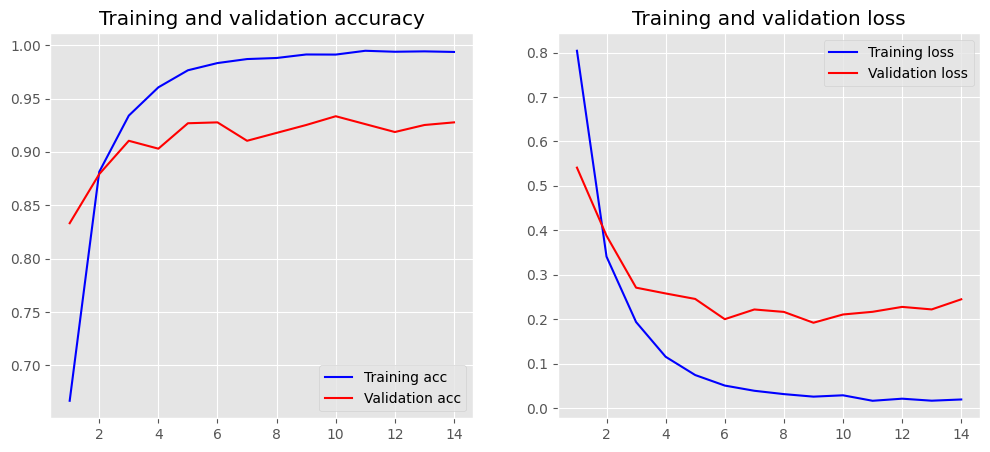

In [26]:
evaluate_model(X_train, y_train, X_test, y_test)
plot_history(history)

## Validation

In [27]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1116,2,Hillary Clinton Campaign Raising $2.5 BILLION ...
2848,4,Stocks finished an erratic session mixed Tuesd...
299,1,"If you are even a slight Dana Carvey fan, you ..."
1991,3,Don't believe what conventional medicine tell...
1994,3,Adaptogenic herbs have beneficial stress adap...


In [34]:
X_val = test_df['text'].values
y_val = test_df['label'].values

# Do the same preprocessing steps as training data: preprocess, tokenize, pad sequences
X_val = [preprocess(sentence) for sentence in X_val]
X_val = [tokenize(sentence) for sentence in X_val]
print("After:", X_val[0])


After: ['when', 'so', 'many', 'actor', 'seem', 'content', 'to', 'churn', 'out', 'performance', 'for', 'a', 'quick', 'paycheck', 'a', 'performer', 'who', 'adheres', 'to', 'his', 'principle', 'really', 'stand', 'out', 'thats', 'why', 'jeff', 'bridge', 'made', 'wave', 'this', 'week', 'when', 'he', 'announced', 'that', 'from', 'now', 'on', 'he', 'will', 'only', 'perform', 'nude', 'scene', 'in', 'an', 'interview', 'in', 'this', 'month', 'gq', 'the', 'big', 'lebowski', 'star', 'made', 'it', 'clear', 'that', 'he', 'wa', 'more', 'than', 'ready', 'to', 'move', 'on', 'to', 'a', 'new', 'phase', 'in', 'his', 'career', 'leaving', 'his', 'clothed', 'role', 'in', 'the', 'past', 'ive', 'been', 'there', 'and', 'ive', 'done', 'that', 'said', 'bridge', 'rattling', 'off', 'a', 'laundry', 'list', 'of', 'the', 'film', 'he', 'appeared', 'in', 'covered', 'up', 'now', 'i', 'can', 'finally', 'afford', 'to', 'only', 'take', 'on', 'role', 'that', 'excite', 'me', 'right', 'now', 'those', 'are', 'role', 'with', 'nu

In [35]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
len(X_val[0])

256

In [43]:
y_pred = model.predict(X_val)
predicted_indexes = np.argmax(y_pred, axis=1)
y_pred_val = [pred_class + 1 for pred_class in predicted_indexes]
y_pred_val

94/94 [==============================] - 1s 8ms/step


[1,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 3,
 2,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 4,
 4,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 4,
 3,
 4,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 2,
 3,
 3,
 1,
 1,
 3,
 4,
 3,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 4,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 3,
 4,
 1,
 4,
 1,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 3,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 3,
 1,
 2,
 3,
 4,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 4,
 3,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 3,
 4,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 1,
 1,


In [44]:
# y_pred_val = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.6353333333333333
F1 score: 0.6238881054637053


In [45]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.72      0.62      0.67       750
        hoax       0.75      0.32      0.45       750
  propaganda       0.49      0.85      0.62       750
    reliable       0.76      0.75      0.75       750

    accuracy                           0.64      3000
   macro avg       0.68      0.64      0.62      3000
weighted avg       0.68      0.64      0.62      3000



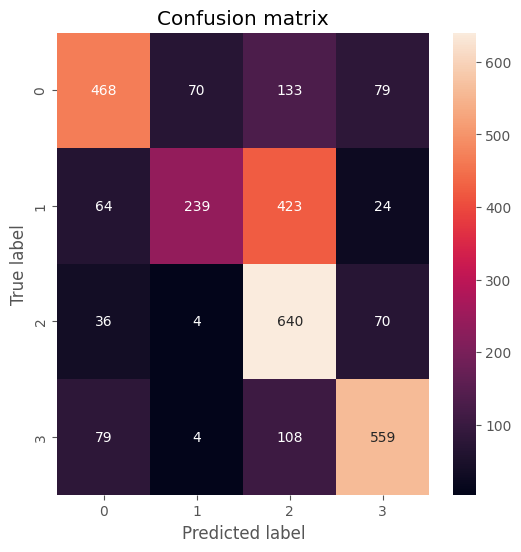

In [46]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	